In [16]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sbs
import torch

### Import data and postprocess

In [8]:
joint_pos = pd.read_csv("joint_pos.csv", delimiter=";", header=None).astype(np.float64).to_numpy()
joint_vel = pd.read_csv("joint_vel.csv", delimiter=";", header=None).astype(np.float64).to_numpy()

#joint_pos = pd.read_csv("joint_pos_muscle.csv", delimiter=";", header=None).astype(np.float64).to_numpy()
#joint_vel = pd.read_csv("joint_vel_muscle.csv", delimiter=";", header=None).astype(np.float64).to_numpy()
actions = pd.read_csv("actions.csv", delimiter=";", header=None).astype(np.float64).to_numpy()[:, 0:-1]

joint_names = ['FL_hip_joint', 'FR_hip_joint', 'RL_hip_joint', 'RR_hip_joint', 'FL_hip_joint', 'FR_hip_joint', 'RL_hip_joint', 'RR_hip_joint', 'FL_calf_joint', 'FR_calf_joint', 'RL_calf_joint', 'RR_calf_joint']

### Plot the raw joint positions and joint velolities as distributions (a, a_dot)

In [18]:
histograms_pos = [np.histogram(row, bins=np.arange(np.min(row), np.max(row) + 0.01, 0.01)) for row in joint_pos.T]
histograms_vel = [np.histogram(row, bins=np.arange(np.min(row), np.max(row) + 0.1, 0.1)) for row in joint_vel.T]

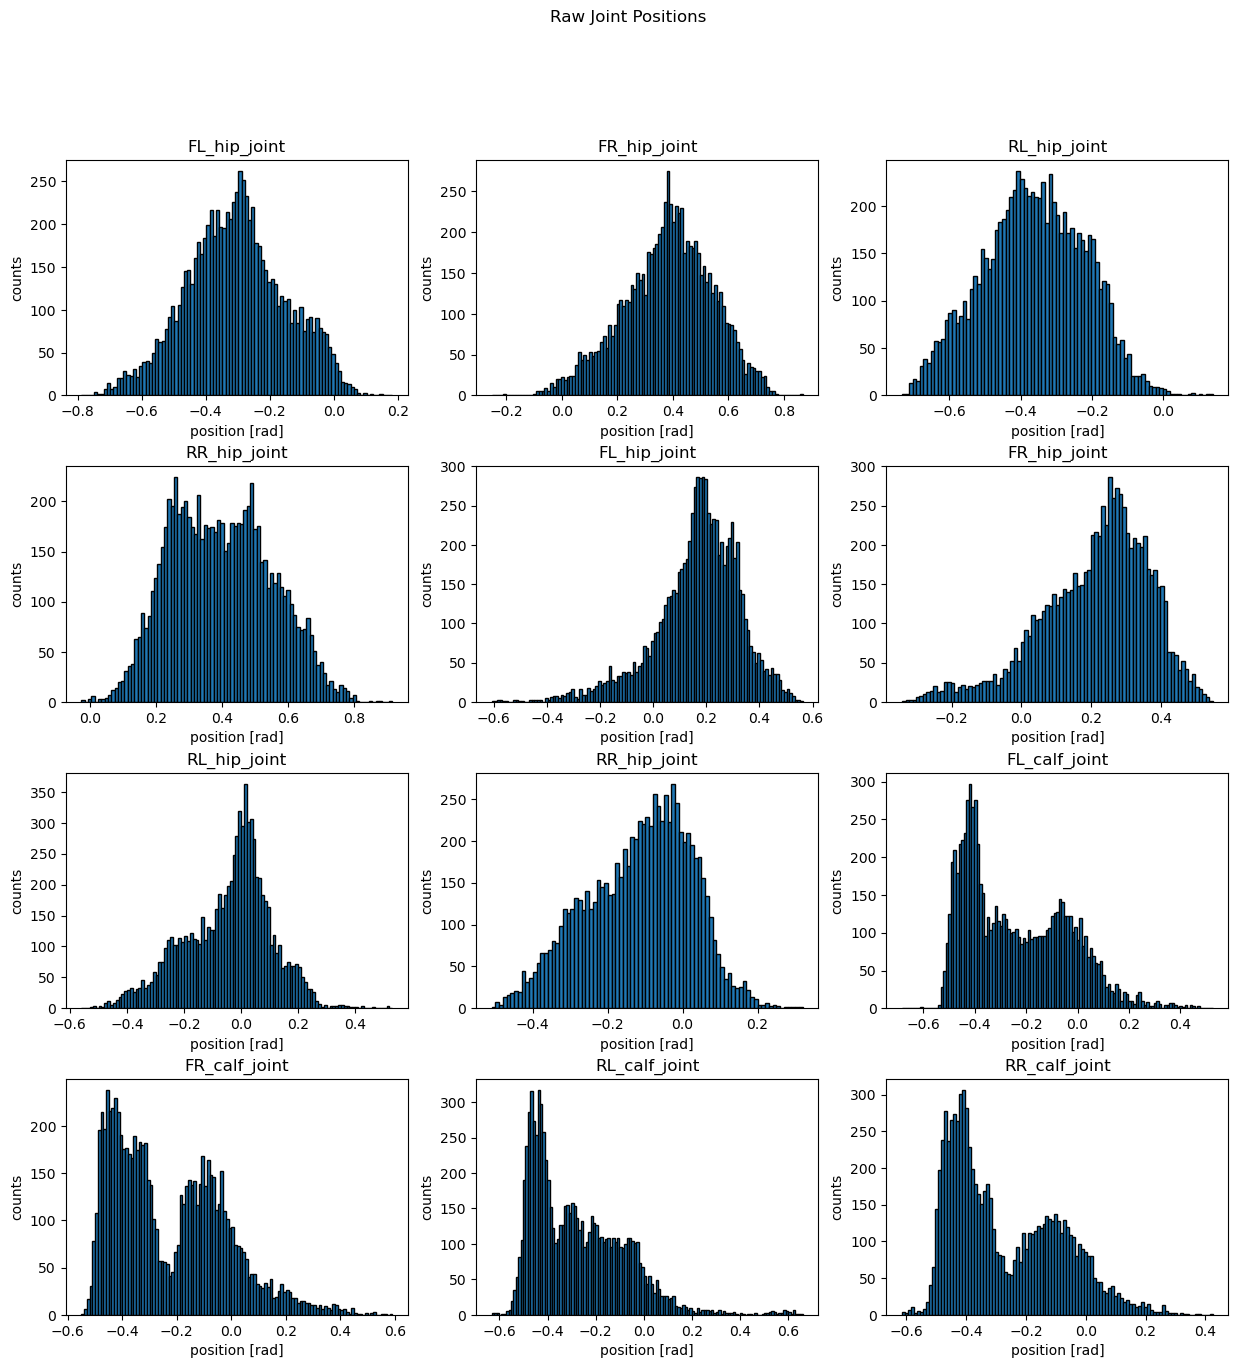

In [19]:
fig, ax = plt.subplots(4, 3, figsize=(15, 15))

fig.subplots_adjust(wspace=0.2, hspace=0.3)

fig.suptitle("Raw Joint Positions")

for i, (counts, bins) in enumerate(histograms_pos):
    width = bins[1] - bins[0]
    centers = bins[:-1] + width / 2
    ax[i // 3, i % 3].bar(centers, counts, width=width, align="edge", edgecolor="black")

    ax[i // 3, i % 3].set_xlabel("position [rad]")
    ax[i // 3, i % 3].set_ylabel("counts")
    ax[i // 3, i % 3].set_title(joint_names[i])


NameError: name 'histograms_vel' is not defined

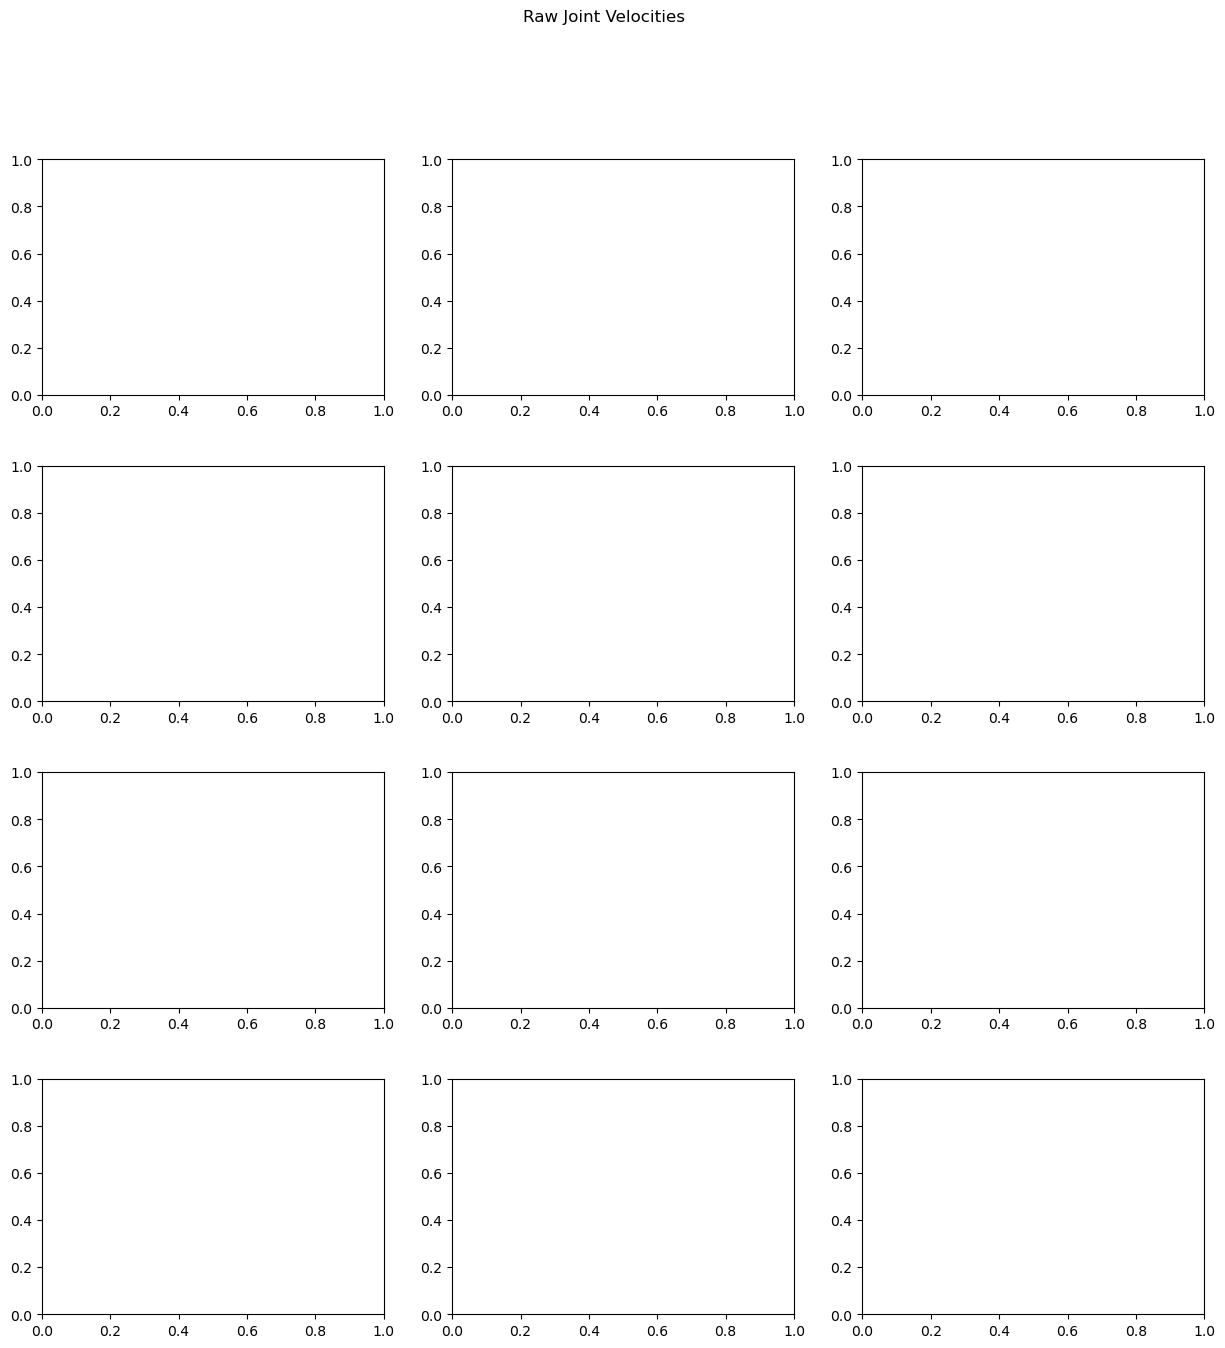

In [9]:
fig, ax = plt.subplots(4, 3, figsize=(15, 15))

fig.subplots_adjust(wspace=0.2, hspace=0.3)

fig.suptitle("Raw Joint Velocities")

for i, (counts, bins) in enumerate(histograms_vel):
    width = bins[1] - bins[0]
    centers = bins[:-1] + width / 2
    ax[i // 3, i % 3].bar(centers, counts, width=width, align="edge", edgecolor="black")

    ax[i // 3, i % 3].set_xlabel("angular velocity [rad/sec]")
    ax[i // 3, i % 3].set_ylabel("counts")
    ax[i // 3, i % 3].set_title(joint_names[i])


### Plot the transformed joint positions and joint velocities as distributions (l, l_dot)

In [21]:
joint_pos.min(), joint_pos.max()

(-0.79302096, 0.9013617)

Currently used muscle params:

In [10]:
muscle_params = {
    "lmin":0.2,
    "lmax":2.0,
    "fvmax": 0.7,
    "fpmax": 2,
    "lce_min": 0.4,
    "lce_max": 1.0,
    "phi_min": -2.7227,
    "phi_max": -0.8,
    "vmax": 30.0, # TODO pierre fragen, ob das das ricthige ist (taken from unitre.py UNITREE_GO2_CFG)
    "peak_force": 45.0,
    "eps": 10e-5 # eps is just a smal number for numerical purpouses
}

device = "cpu"

In [11]:
torch.set_default_dtype(torch.float32)

class MuscleModel:
    def __init__(self, muscle_params, action_tensor, nenvironments):
        super().__init__
        self.device = "cpu"
        self.nactioncount = action_tensor.shape[1]
        self.nenvironments = nenvironments

        for k, v in muscle_params.items():
            setattr(self, k, v)

        self.phi_min = (
            torch.ones(
                (nenvironments, action_tensor.shape[1] // 2),
                dtype=torch.float32,
                device=self.device,
                requires_grad=False,
            )
            * self.phi_min
        )
        self.phi_max = (
            torch.ones(
                (nenvironments, action_tensor.shape[1] // 2),
                dtype=torch.float32,
                device=self.device,
                requires_grad=False,
            )
            * self.phi_max
        )
        self.activation_tensor = torch.zeros_like(
            action_tensor,
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.lce_tensor = torch.zeros_like(
            action_tensor,
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.lce_dot_tensor = torch.zeros_like(
            action_tensor,
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.force_tensor = torch.zeros_like(
            action_tensor,
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.lce_1_tensor = torch.zeros(
            (self.nenvironments, action_tensor.shape[1]),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.lce_2_tensor = torch.zeros(
            (self.nenvironments, action_tensor.shape[1]),
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )
        self.moment, self.lce_ref = self.compute_parametrization(action_tensor)

        self.episode_steps = 0

    def analyse_muscle(self):
        pass

    def FL(self, lce: torch.Tensor) -> torch.Tensor:
        """
        Force length
        """
        length = lce
        b1 = self.bump(length, self.lmin, 1, self.lmax)
        b2 = self.bump(length, self.lmin, 0.5 * (self.lmin + 0.95), 0.95)
        bump_res = b1 + 0.15 * b2
        return bump_res

    def bump(self, length: torch.Tensor, A: float, mid: float, B: float) -> torch.Tensor:
        """
        skewed bump function: quadratic spline
        Input:
            :length: tensor of muscle lengths [Nenv, Nactuator]
            :A: scalar
            :mid: scalar
            :B: scalar

        Returns:
            :torch.Tensor: contains FV result [Nenv, Nactuator]
        """

        left = 0.5 * (A + mid)
        right = 0.5 * (mid + B)
        # Order of assignment needs to be inverse to the if-else-clause case
        bump_result = torch.ones_like(
            length,
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )

        x = (B - length) / (B - right)
        bump_result = 0.5 * x * x

        x = (length - mid) / (right - mid)
        bump_result = torch.where(length < right, 1 - 0.5 * x * x, bump_result)

        x = (mid - length) / (mid - left)
        bump_result = torch.where(length < mid, 1 - 0.5 * x * x, bump_result)

        x = (length - A) / (left - A)
        bump_result = torch.where((length < left) & (length > A), 0.5 * x * x, bump_result)

        bump_result = torch.where(
            torch.logical_or((length <= A), (length >= B)),
            torch.tensor([0], dtype=torch.float32, device=self.device),
            bump_result,
        )
        return bump_result

    def FV(self, lce_dot: torch.Tensor) -> torch.Tensor:
        """
        Force velocity
        Input:
            :lce_dot: tensor of muscle velocities [Nenv, Nactuator]
        """
        c = self.fvmax - 1
        velocity = lce_dot

        eff_vel = torch.div(velocity, self.vmax)

        c_result = torch.zeros_like(
            eff_vel,
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )

        c_result = torch.where(
            (eff_vel > c),
            torch.tensor([self.fvmax], dtype=torch.float32, device=self.device),
            c_result,
        )

        x = torch.sub(
            self.fvmax,
            torch.div(torch.mul(torch.sub(c, eff_vel), torch.sub(c, eff_vel)), c),
        )
        c_result = torch.where(eff_vel <= c, x, c_result)

        x = torch.mul(torch.add(eff_vel, 1), torch.add(eff_vel, 1))
        c_result = torch.where(eff_vel <= 0, x, c_result)

        c_result = torch.where(
            (eff_vel < -1),
            torch.tensor([0], dtype=torch.float32, device=self.device),
            c_result,
        )

        return c_result

    def FP(self, lce: torch.Tensor) -> torch.Tensor:
        """
        Force passive
        Inputs:
            :lce: muscle lengths [Nenv, Nactuator]
        return :fp_result: passive_force [Nenv, Nactuator]
        """
        b = 0.5 * (self.lmax + 1)

        # Order of assignment needs to be inverse to the if-else-clause case
        ## method to prevent
        cond_2_tmp = torch.div(torch.sub(lce, 1), (b - 1))
        cond_2 = torch.mul(
            torch.mul(torch.mul(cond_2_tmp, cond_2_tmp), cond_2_tmp),
            (0.25 * self.fpmax),
        )

        cond_3_tmp = torch.div(torch.sub(lce, b), (b - 1))
        cond_3 = torch.mul(torch.add(torch.mul(cond_3_tmp, 3), 1), (0.25 * self.fpmax))
        ##### copy based on condition the correct output into new tensor
        c_result = torch.zeros_like(lce, dtype=torch.float32, device=self.device, requires_grad=False)
        c_result = torch.where(lce <= b, cond_2, c_result)
        c_result = torch.where(
            lce <= 1,
            torch.tensor([0], dtype=torch.float32, device=self.device),
            c_result,
        )
        c_result = torch.where(lce > b, cond_3, c_result)

        return c_result

    def compute_parametrization(self, action_tensor):
        """
        Find parameters for muscle length computation.
        This should really only be done once...

        We compute them as one long vector now.
        """
        moment = torch.zeros_like(action_tensor)
        moment[:, : int(moment.shape[1] // 2)] = (self.lce_max - self.lce_min + self.eps) / (self.phi_max - self.phi_min + self.eps)
        moment[:, int(moment.shape[1] // 2) :] = (self.lce_max - self.lce_min + self.eps) / (self.phi_min - self.phi_max + self.eps)
        lce_ref = torch.zeros_like(action_tensor)
        lce_ref[:, : int(lce_ref.shape[1] // 2)] = self.lce_min - moment[:, : int(moment.shape[1] // 2)] * self.phi_min
        lce_ref[:, int(lce_ref.shape[1] // 2) :] = self.lce_min - moment[:, int(moment.shape[1] // 2) :] * self.phi_max
        return moment, lce_ref

    def compute_virtual_lengths(self, actuator_pos: torch.Tensor) -> None:
        """
        Compute muscle fiber lengths l_ce depending on joint angle
        Attention: The mapping of actuator_trnid to qvel is only 1:1 because we have only
        slide or hinge joints and no free joint!!! Otherwise you have to build this mapping
        by looking at every single joint type.

        self.lce_x_tensor contains copy of given actions (they represent the actuator position)
        """
        # Repeat position tensor twice, because both muscles are computed from the same actuator position
        # the operation is NOT applied in-place to the original tensor, only the result is repeated.
        self.lce_tensor = torch.add(torch.mul(actuator_pos.repeat(1, 2), self.moment), self.lce_ref)
        return self.lce_tensor

    def get_peak_force(self, actuator_vel):
        """
        acceleration from unit force in qpos0 is contained within self.dof_vel
        """
        ### at the moment not used because solo8/12 have the same actuators and therefore no requirement to be dynamic
        raise NotImplementedError
        force = 5000
        scale = 200

        c_result = torch.zeros_like(
            actuator_vel,
            dtype=torch.float32,
            device=self.device,
            requires_grad=False,
        )

        for i, c_vel in enumerate(actuator_vel):
            if (force + 1) < 0.01:
                c_result[i] = torch.div(scale, c_vel)
            else:
                c_result[i] = force
        return c_result

    def get_vel(self, moment, actuator_vel: torch.Tensor) -> torch.Tensor:
        """
        For muscle 1, the joint angle increases if it pulls. This means
        that the joint and the muscle velocity have opposite signs. But this is already
        included in the value of the moment arm. So we don't need if/else branches here.
        Attention: The mapping of actuator_trnid to qvel is only 1:1 because we have only
        slide or hinge joints and no free joint!!! Otherwise you have to build this mapping
        by looking at every single joint type.
        """
        return torch.mul(actuator_vel.repeat(1, 2), moment)

    def activ_dyn(self, actions: torch.Tensor) -> None:
        """
        Activity and controls have to be written inside userdata. Assume
        two virtual muscles per real mujoco actuator and let's roll.
        """
        sim_timestep = 0.005
        self.activation_tensor = 100 * (actions - self.activation_tensor) * sim_timestep + self.activation_tensor
        self.activation_tensor = torch.clip(self.activation_tensor, 0, 1)
        # self.activation_tensor = torch.mul(torch.mul(torch.sub(actions,self.activation_tensor), 100), torch.add(self.activation_tensor, sim_timestep))

    def compute_moment(self, actions, actuator_vel, lce_1, lce_2):
        """
        Joint moments are computed from muscle contractions and then returned
        """
        self.lce_dot_tensor = self.get_vel(self.moment, actuator_vel)
        lce_dot = self.lce_dot_tensor
        lce_tensor = self.lce_tensor

        FL = self.FL(lce_tensor)
        FV = self.FV(lce_dot)
        FP = self.FP(lce_tensor)
        #print(FL, FV, FP)

        self.force_tensor = torch.add(torch.mul(torch.mul(FL, FV), self.activation_tensor), FP)
        F = torch.mul(self.force_tensor, self.peak_force)
        torque = F * self.moment

        return torch.sum(
            torch.reshape(torque, (self.nenvironments, 2, self.nactioncount // 2)),
            axis=-2,
        )

    def compute_torques(self, actuator_pos, actuator_vel, actions: torch.Tensor):
        """
        actuator_pos: Current position of actuator
        """

        with torch.torch.no_grad():
            actions = torch.clip(actions, 0, 1)

            # activity funciton for muscle activation
            self.activ_dyn(actions)

            # update virtual lengths
            self.compute_virtual_lengths(actuator_pos)

            # compute moments
            moment = self.compute_moment(actions, actuator_vel, self.lce_1_tensor, self.lce_2_tensor)

            return moment


muscle = MuscleModel(muscle_params, torch.zeros(1, 24), 1)

In [12]:
joint_pos_l = muscle.compute_virtual_lengths(torch.Tensor(joint_pos)).clone()
joint_vel_l = muscle.get_vel(torch.Tensor(joint_pos_l), torch.Tensor(joint_vel)).clone()

In [13]:
histograms_pos_l = [np.histogram(row, bins=np.arange(np.min(row), np.max(row) + 0.001, 0.001)) for row in joint_pos_l.numpy().reshape(joint_pos.shape[0], 2, 12).transpose(0, 2, 1).reshape(joint_pos.shape[0], 24).T]
histograms_vel_l = [np.histogram(row, bins=np.arange(np.min(row), np.max(row) + 0.1, 0.1)) for row in joint_vel_l.numpy().reshape(joint_pos.shape[0], 2, 12).transpose(0, 2, 1).reshape(joint_pos.shape[0], 24).T]

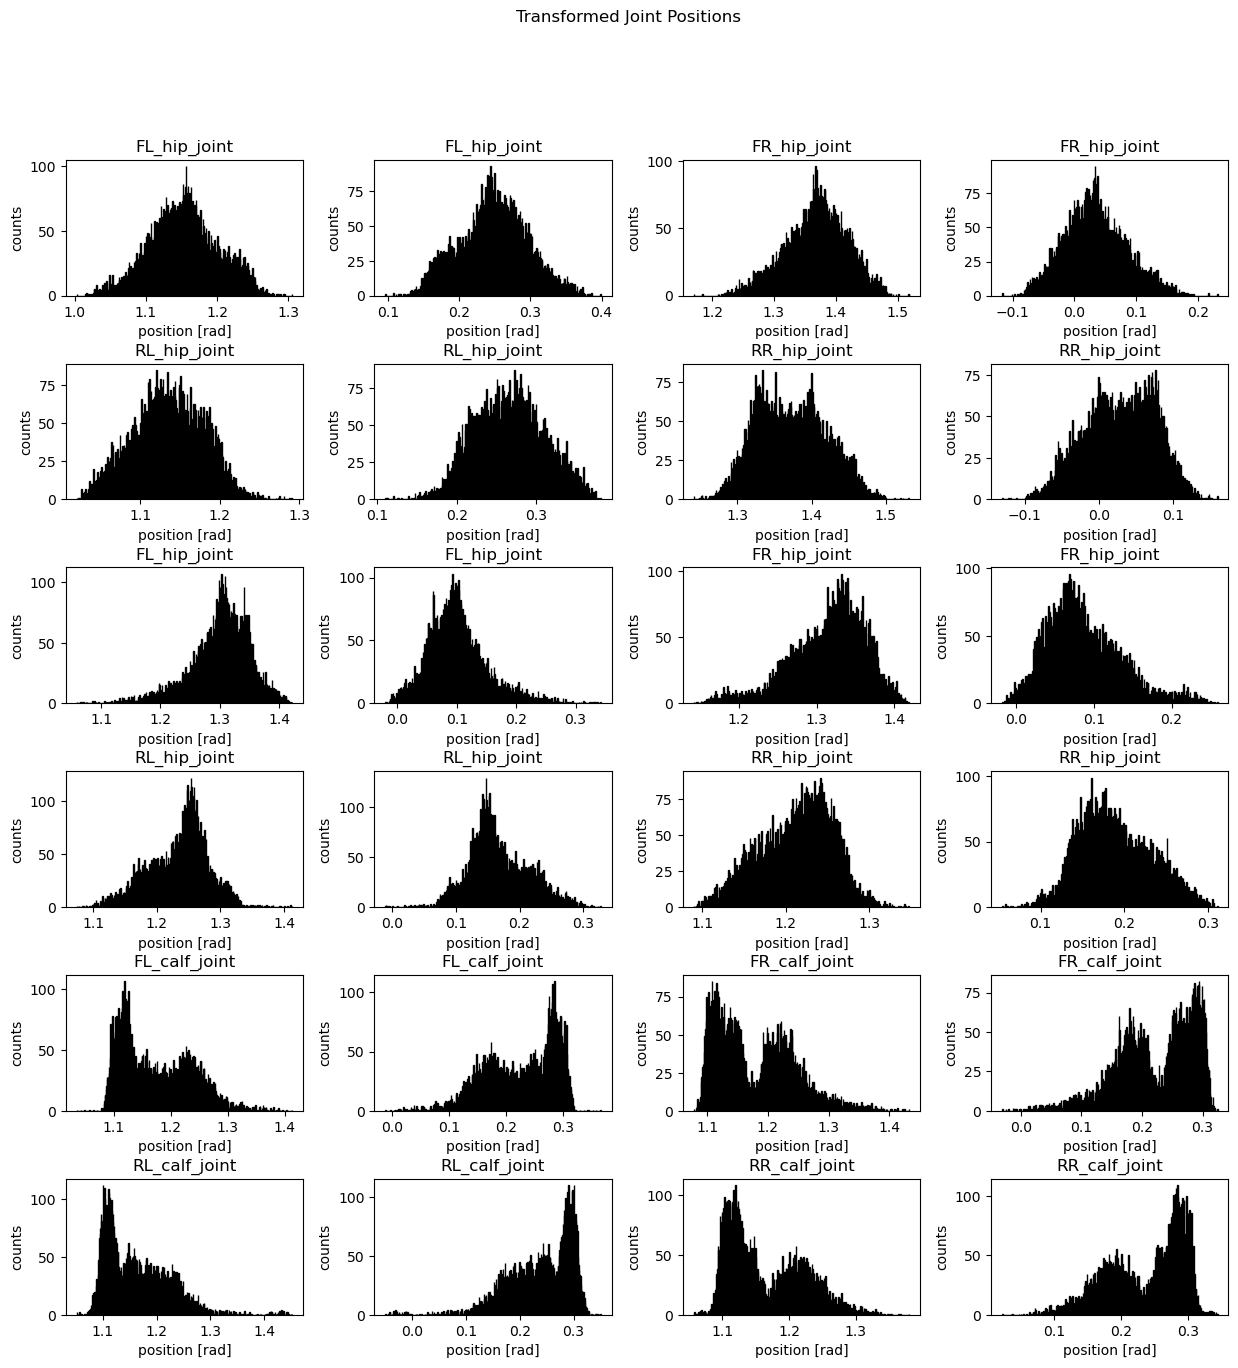

In [14]:

rows = 6
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(15, 15))

fig.subplots_adjust(wspace=0.3, hspace=0.5)

fig.suptitle("Transformed Joint Positions")

for i, (counts, bins) in enumerate(histograms_pos_l):
    width = bins[1] - bins[0]
    centers = bins[:-1] + width / 2
    ax[i // cols, i % cols].bar(centers, counts, width=width, align="edge", edgecolor="black")

    ax[i // cols, i % cols].set_xlabel("position [rad]")
    ax[i // cols, i % cols].set_ylabel("counts")
    ax[i // cols, i % cols].set_title(joint_names[i // 2])

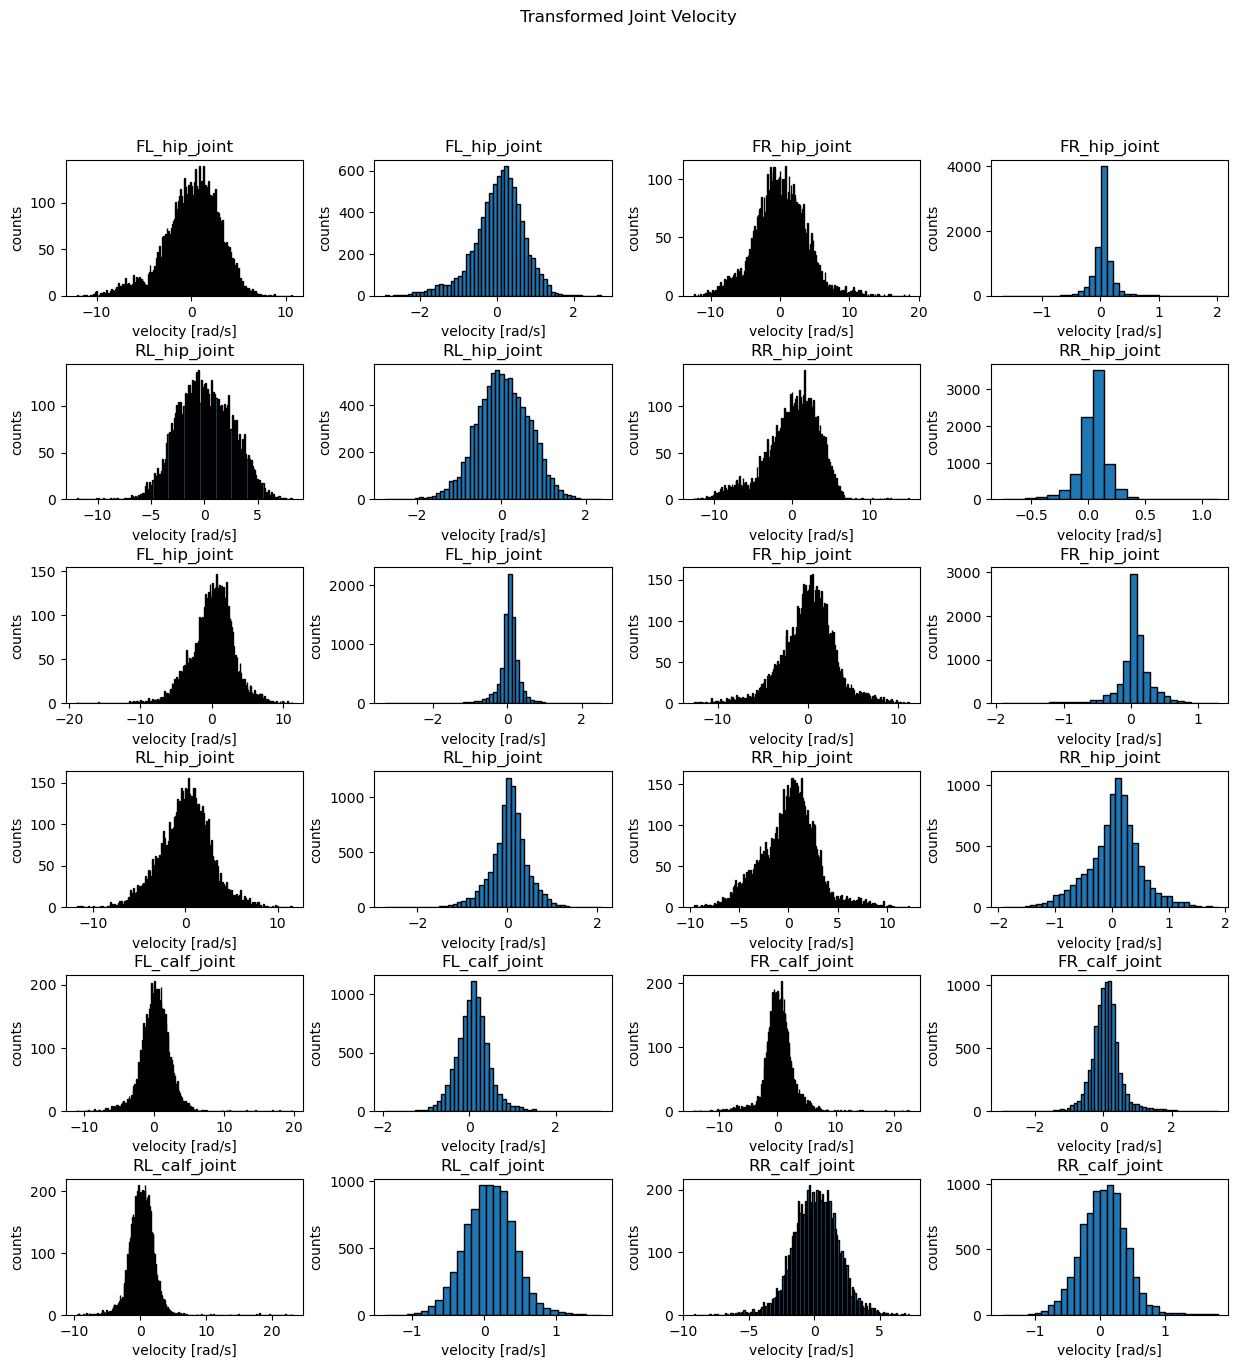

In [15]:
rows = 6
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(15, 15))

fig.subplots_adjust(wspace=0.3, hspace=0.5)

fig.suptitle("Transformed Joint Velocity")

for i, (counts, bins) in enumerate(histograms_vel_l):
    width = bins[1] - bins[0]
    centers = bins[:-1] + width / 2
    ax[i // cols, i % cols].bar(centers, counts, width=width, align="edge", edgecolor="black")

    ax[i // cols, i % cols].set_xlabel("velocity [rad/s]")
    ax[i // cols, i % cols].set_ylabel("counts")
    ax[i // cols, i % cols].set_title(joint_names[i // 2])

### ???
I don't understand how we can get l by doing l = aq + b, altough we always have 2 muscles -> lets just assume, we use 1 muscles (my mooscles are getting bigger)

In [16]:
fls = muscle.FL(joint_pos_l)
fvs = muscle.FV(joint_vel_l)
fps = muscle.FP(joint_pos_l)

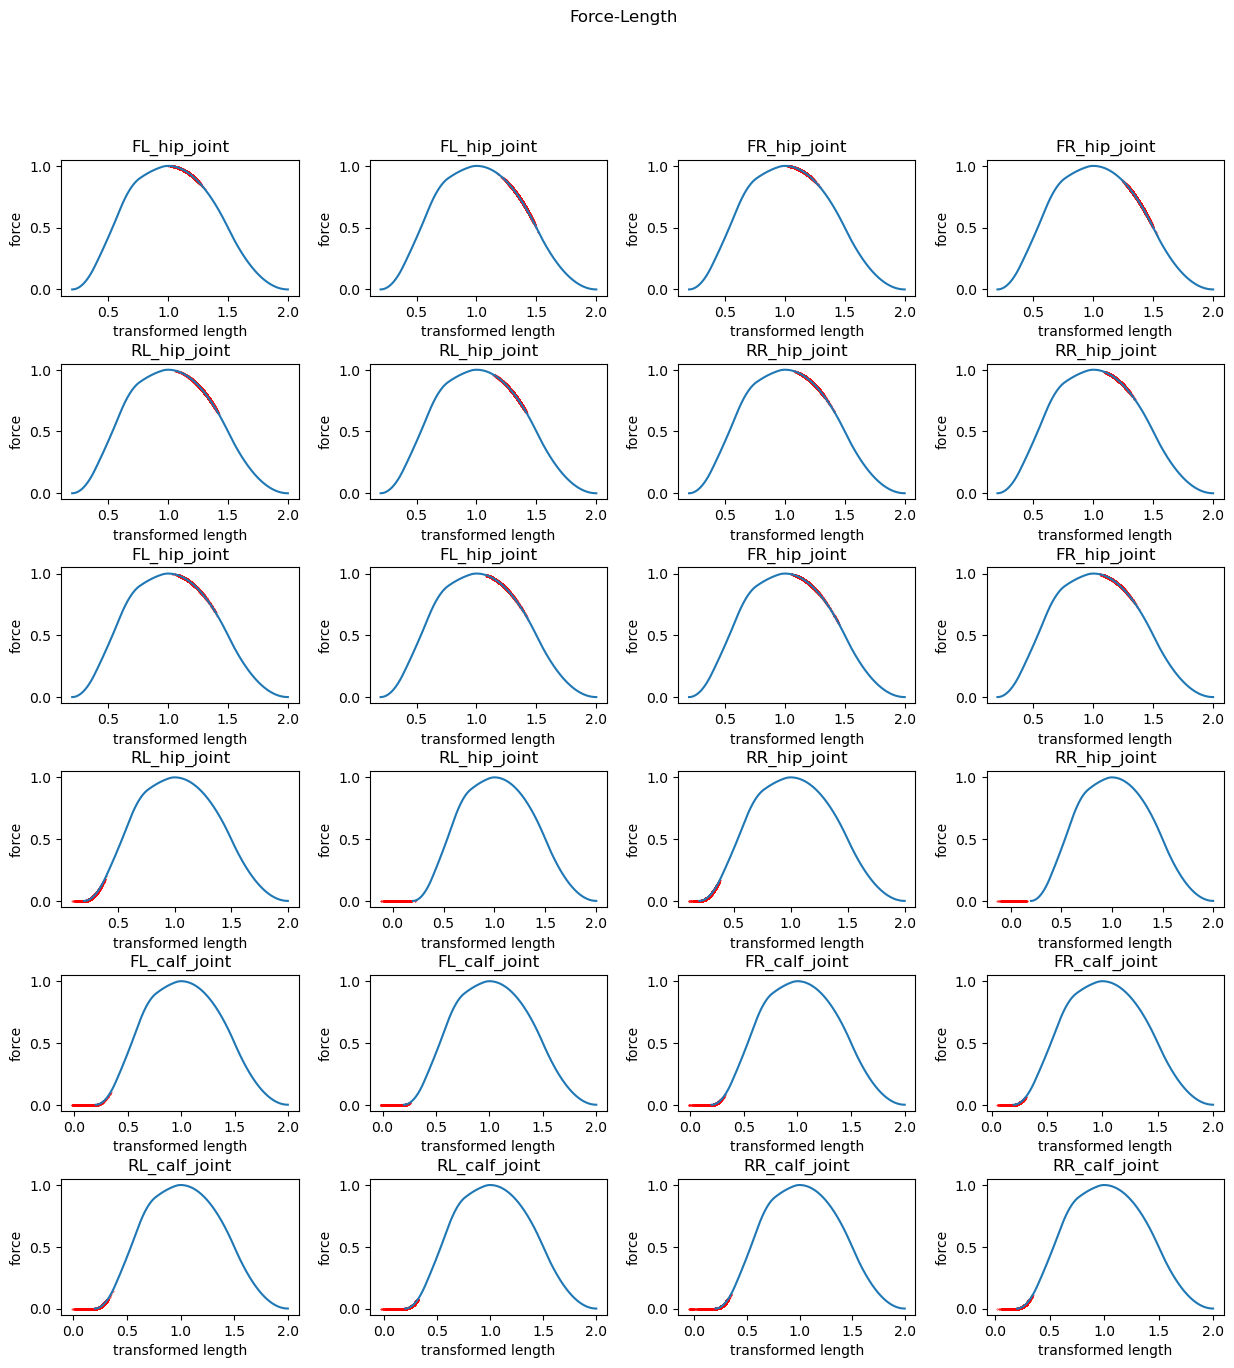

In [17]:
rows = 6
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(15, 15))

fig.subplots_adjust(wspace=0.3, hspace=0.5)

fig.suptitle("Force-Length")

for i, col in enumerate(joint_pos_l.T):
    x = np.linspace(muscle_params["lmin"], muscle_params["lmax"], 1000)
    y = muscle.FL(torch.Tensor(x))
    ax[i // cols, i % cols].plot(x, y)

    ax[i // cols, i % cols].scatter(x=col, y=fls.T[i], s=0.1, color="red")

    ax[i // cols, i % cols].set_xlabel("transformed length")
    ax[i // cols, i % cols].set_ylabel("force")
    ax[i // cols, i % cols].set_title(joint_names[i // 2])

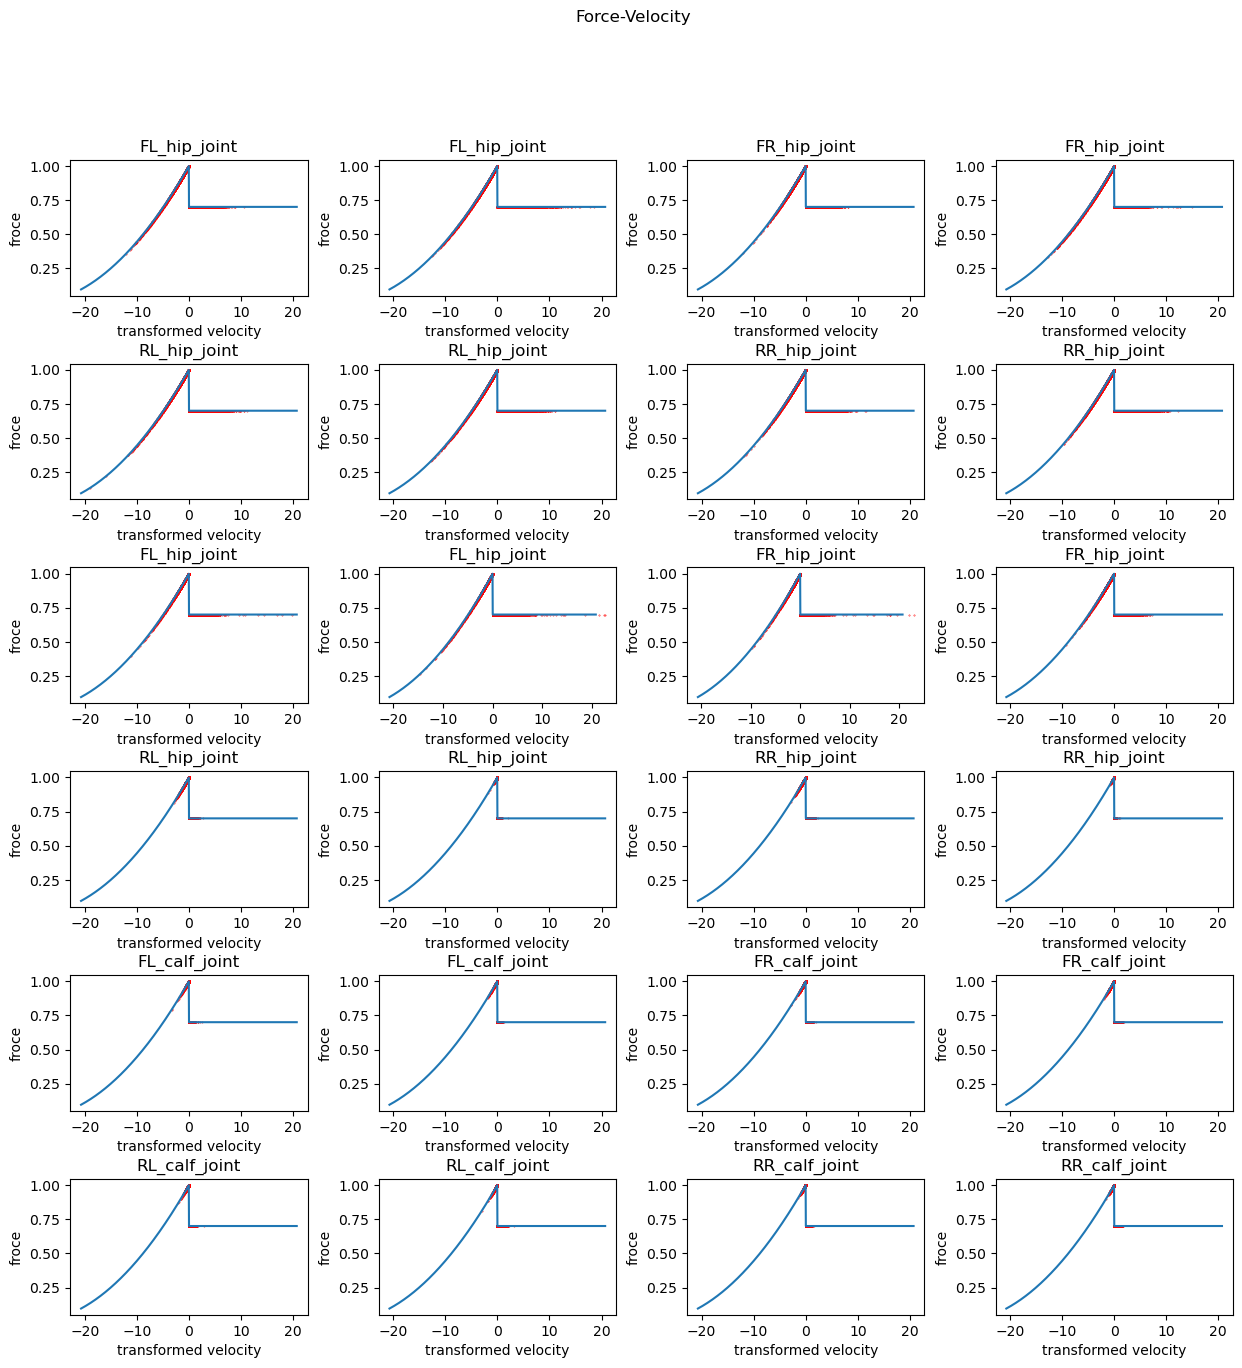

In [18]:

rows = 6
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(15, 15))

fig.subplots_adjust(wspace=0.3, hspace=0.5)

fig.suptitle("Force-Velocity")

for i, col in enumerate(joint_vel_l.T):
    x = np.linspace(-muscle_params["fvmax"] - 20, muscle_params["fvmax"] + 20, 1000)
    y = muscle.FV(torch.Tensor(x))
    ax[i // cols, i % cols].plot(x, y)

    ax[i // cols, i % cols].scatter(x=col, y=fvs.T[i], s=0.1, color="red")

    ax[i // cols, i % cols].set_xlabel("transformed velocity")
    ax[i // cols, i % cols].set_ylabel("froce")
    ax[i // cols, i % cols].set_title(joint_names[i // 2])

In [19]:
fps.T[0].shape

torch.Size([8333])

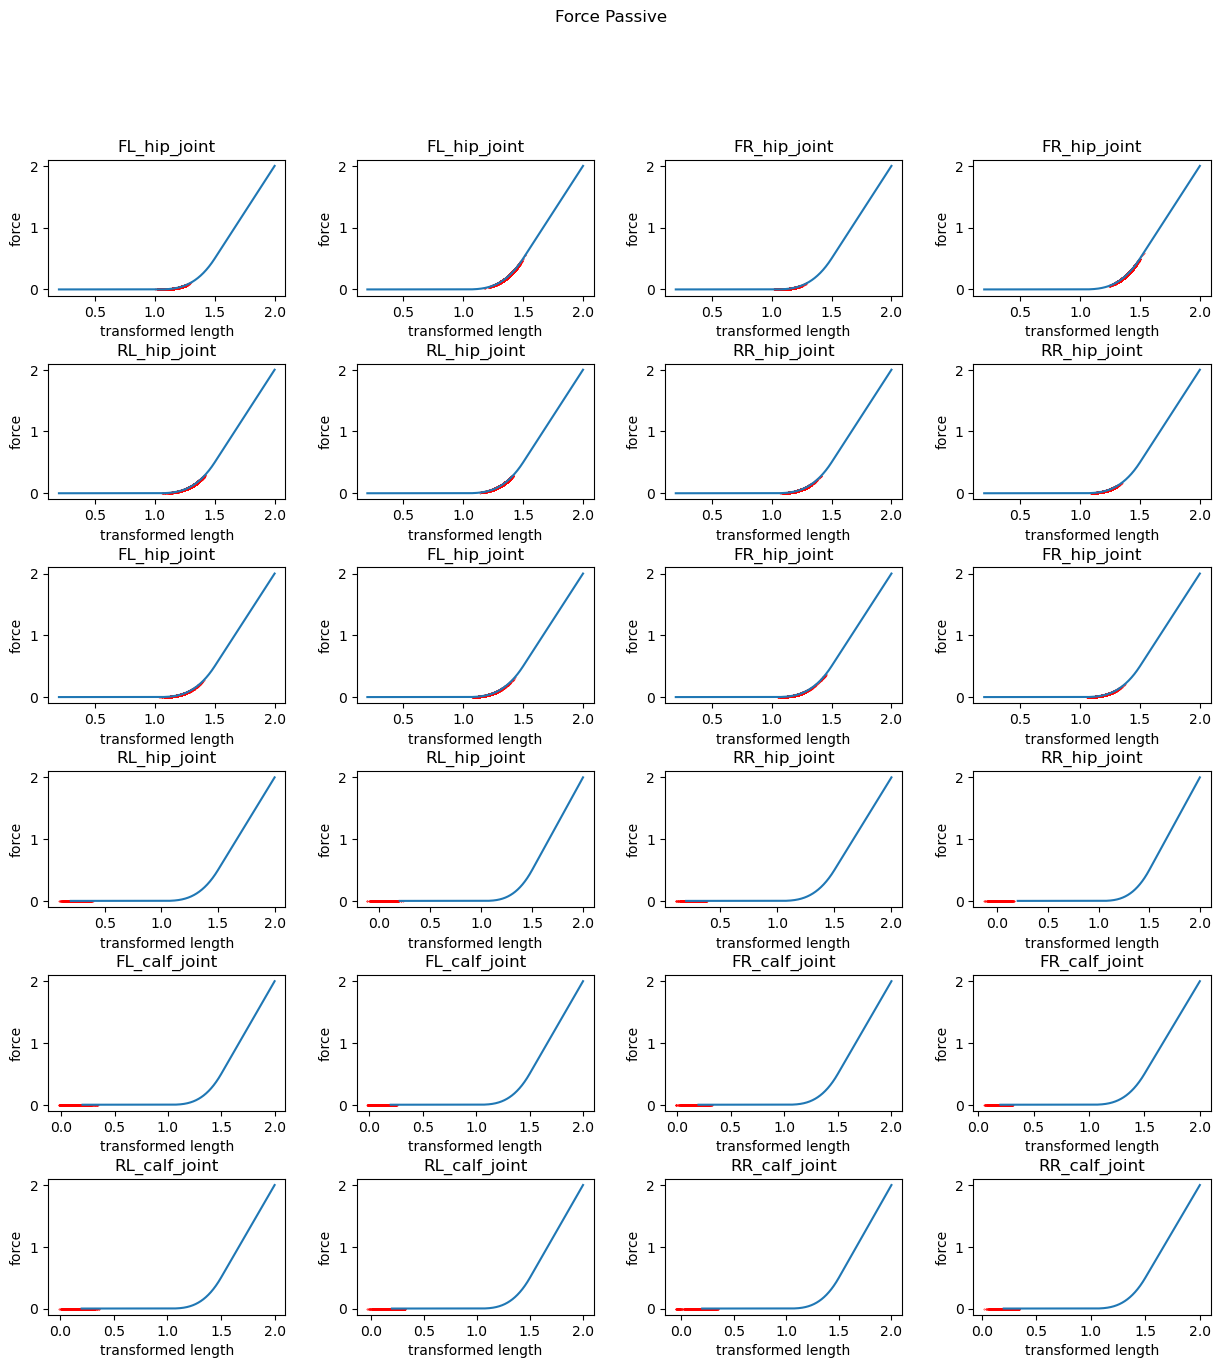

In [20]:

rows = 6
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(15, 15))

fig.subplots_adjust(wspace=0.3, hspace=0.5)

fig.suptitle("Force Passive")

for i, col in enumerate(joint_pos_l.T):
    x = np.linspace(muscle_params["lmin"], muscle_params["lmax"], 1000)
    y = muscle.FP(torch.Tensor(x))
    ax[i // cols, i % cols].plot(x, y)

    ax[i // cols, i % cols].scatter(x=col, y=fps.T[i], s=0.1, color="red")

    ax[i // cols, i % cols].set_xlabel("transformed length")
    ax[i // cols, i % cols].set_ylabel("force")
    ax[i // cols, i % cols].set_title(joint_names[i // 2])

In [21]:
torch.Tensor([1.0] * 24).repeat(100, 1).shape
torch.Tensor(joint_pos[0]).shape

torch.Size([12])

In [34]:
a = torch.zeros(1, 24)
a[0, 12:] = 1.0
a


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.]])

In [22]:
torques = np.array([muscle.compute_torques(torch.Tensor(joint_pos[i]), torch.Tensor(joint_vel[i]), a) for i in range(len(joint_pos))])

NameError: name 'a' is not defined

In [36]:
torques.min(), torques.max()

(-2.4227967, 8.330768)

In [23]:
muscle_params_calf = {
    "lmin":0.2,
    "lmax":2.0,
    "fvmax": 0.8,
    "fpmax": 2,
    "lce_min": 0.75,
    "lce_max": 0.92,
    "phi_min": -2.7227,
    "phi_max": -0.8,
    "vmax": 30.0, # TODO pierre fragen, ob das das ricthige ist (taken from unitre.py UNITREE_GO2_CFG)
    "peak_force": 45.0,
    "eps": 10e-5 # eps is just a smal number for numerical purpouses
}

muscle_params_thigh_front = {
    "lmin":0.2,
    "lmax":2.0,
    "fvmax": 0.8,
    "fpmax": 2,
    "lce_min": 0.75,
    "lce_max": 0.92,
    "phi_min": -1.5708,
    "phi_max": 3.4907,
    "vmax": 30.0, # TODO pierre fragen, ob das das ricthige ist (taken from unitre.py UNITREE_GO2_CFG)
    "peak_force": 45.0,
    "eps": 10e-5 # eps is just a smal number for numerical purpouses
}

muscle_params_thigh_back = {
    "lmin":0.2,
    "lmax":2.0,
    "fvmax": 0.8,
    "fpmax": 2,
    "lce_min": 0.75,
    "lce_max": 0.92,
    "phi_min": -0.5236,
    "phi_max": 4.5378,
    "vmax": 30.0, # TODO pierre fragen, ob das das ricthige ist (taken from unitre.py UNITREE_GO2_CFG)
    "peak_force": 45.0,
    "eps": 10e-5 # eps is just a smal number for numerical purpouses
}

muscle_params_hip = {
    "lmin":0.2,
    "lmax":2.0,
    "fvmax": 0.8,
    "fpmax": 2,
    "lce_min": 0.75,
    "lce_max": 0.92,
    "phi_min": -1.0471,
    "phi_max": 1.0471,
    "vmax": 30.0, # TODO pierre fragen, ob das das ricthige ist (taken from unitre.py UNITREE_GO2_CFG)
    "peak_force": 45.0,
    "eps": 10e-5 # eps is just a smal number for numerical purpouses
}

In [24]:
thigh_front_min_angle, thigh_front_max_angle = -1.5708, 3.4907
thigh_back_min_angle, thigh_back_max_angle = -0.5236, 4.5378
calf_min_angle, calf_max_angle = -2.7227, -0.8 
hip_min_angle, hip_max_angle = -1.0471, 1.0471
num_points = 1000

fr_thigh = torch.linspace(thigh_front_min_angle, thigh_front_max_angle, num_points).unsqueeze(0)
fl_thigh = torch.linspace(thigh_front_min_angle, thigh_front_max_angle, num_points).unsqueeze(0)
rr_thigh = torch.linspace(thigh_back_min_angle, thigh_back_max_angle, num_points).unsqueeze(0)
rl_thigh = torch.linspace(thigh_back_min_angle, thigh_back_max_angle, num_points).unsqueeze(0)

fr_hip = torch.linspace(hip_min_angle, hip_max_angle, num_points).unsqueeze(0)
fl_hip = torch.linspace(hip_min_angle, hip_max_angle, num_points).unsqueeze(0)
rr_hip = torch.linspace(hip_min_angle, hip_max_angle, num_points).unsqueeze(0)
rl_hip = torch.linspace(hip_min_angle, hip_max_angle, num_points).unsqueeze(0)

fr_calf = torch.linspace(calf_min_angle, calf_max_angle, num_points).unsqueeze(0)
fl_calf = torch.linspace(calf_min_angle, calf_max_angle, num_points).unsqueeze(0)
rr_calf = torch.linspace(calf_min_angle, calf_max_angle, num_points).unsqueeze(0)
rl_calf = torch.linspace(calf_min_angle, calf_max_angle, num_points).unsqueeze(0)

muscle_thigh_front = MuscleModel(muscle_params_thigh_front, torch.zeros(1, 4, device=device), 1)
muscle_thigh_back = MuscleModel(muscle_params_thigh_back, torch.zeros(1, 4, device=device), 1)
muscle_hip = MuscleModel(muscle_params_hip, torch.zeros(1, 8, device=device), 1)
muscle_calf = MuscleModel(muscle_params_calf, torch.zeros(1, 8, device=device), 1)


In [25]:
front_thigh_le = muscle_thigh_front.compute_virtual_lengths(torch.concatenate([fr_thigh, fl_thigh]).T)
back_thigh_le = muscle_thigh_back.compute_virtual_lengths(torch.concatenate([rr_thigh, rl_thigh]).T)
hip_le = muscle_hip.compute_virtual_lengths(torch.concatenate([fr_hip, fl_hip, rr_hip, rl_hip]).T)
calf_le = muscle_calf.compute_virtual_lengths(torch.concatenate([fr_calf, fl_calf, rr_calf, rl_calf]).T)

In [40]:
hip_le

tensor([[0.7500, 0.7500, 0.7500,  ..., 0.9201, 0.9201, 0.9201],
        [0.7502, 0.7502, 0.7502,  ..., 0.9199, 0.9199, 0.9199],
        [0.7503, 0.7503, 0.7503,  ..., 0.9198, 0.9198, 0.9198],
        ...,
        [0.9198, 0.9198, 0.9198,  ..., 0.7503, 0.7503, 0.7503],
        [0.9199, 0.9199, 0.9199,  ..., 0.7502, 0.7502, 0.7502],
        [0.9201, 0.9201, 0.9201,  ..., 0.7500, 0.7500, 0.7500]])

In [26]:
front_thigh_FL = muscle_thigh_front.FL(front_thigh_le)
back_thigh_FL = muscle_thigh_back.FL(back_thigh_le)
hip_FL = muscle_hip.FL(hip_le)
calf_FL = muscle_calf.FL(calf_le)

In [42]:
hip_FL

tensor([[0.8894, 0.8894, 0.8894,  ..., 0.9820, 0.9820, 0.9820],
        [0.8895, 0.8895, 0.8895,  ..., 0.9819, 0.9819, 0.9819],
        [0.8896, 0.8896, 0.8896,  ..., 0.9818, 0.9818, 0.9818],
        ...,
        [0.9818, 0.9818, 0.9818,  ..., 0.8896, 0.8896, 0.8896],
        [0.9819, 0.9819, 0.9819,  ..., 0.8895, 0.8895, 0.8895],
        [0.9820, 0.9820, 0.9820,  ..., 0.8894, 0.8894, 0.8894]])

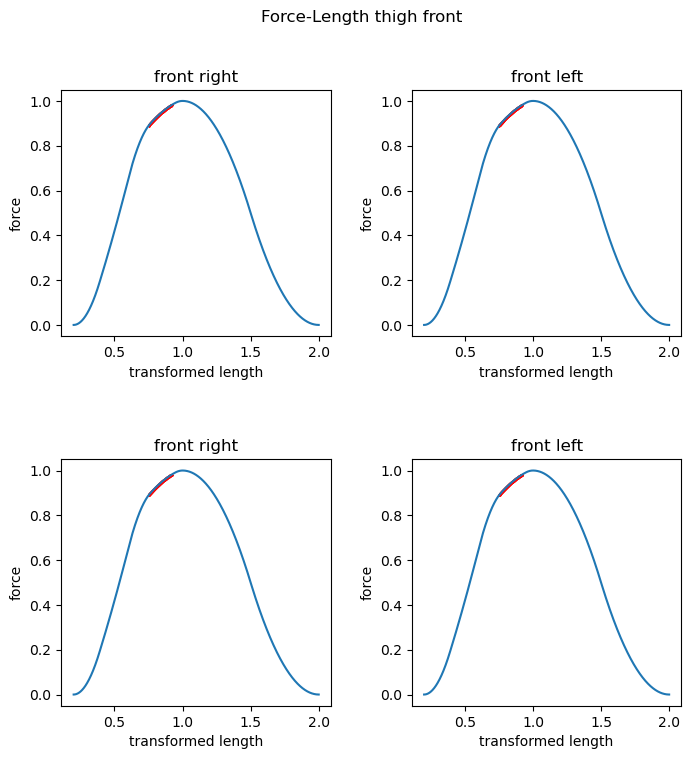

In [27]:
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(8, 8))

fig.subplots_adjust(wspace=0.3, hspace=0.5)

fig.suptitle("Force-Length thigh front")

for i, col in enumerate(front_thigh_le.T):
    x = np.linspace(muscle_params_thigh_front["lmin"], muscle_params_thigh_front["lmax"], 1000)
    y = muscle_thigh_front.FL(torch.Tensor(x))
    ax[i // cols, i % cols].plot(x, y)

    ax[i // cols, i % cols].scatter(x=col, y=front_thigh_FL.T[i], s=0.1, color="red")

    ax[i // cols, i % cols].set_xlabel("transformed length")
    ax[i // cols, i % cols].set_ylabel("force")
    ax[i // cols, i % cols].set_title("front right" if i % 2 == 0 else "front left")

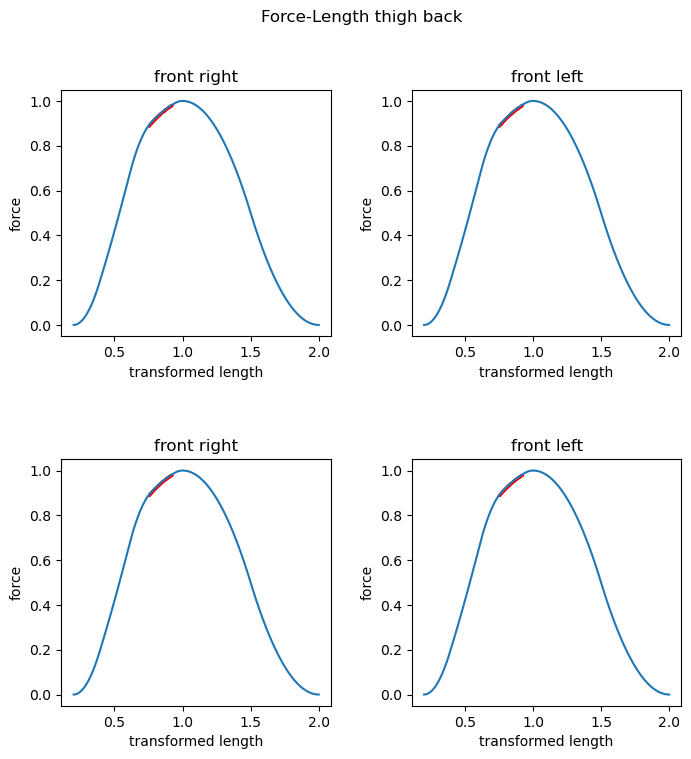

In [44]:
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(8, 8))

fig.subplots_adjust(wspace=0.3, hspace=0.5)

fig.suptitle("Force-Length thigh back")

for i, col in enumerate(back_thigh_le.T):
    x = np.linspace(muscle_params_thigh_back["lmin"], muscle_params_thigh_back["lmax"], 1000)
    y = muscle_thigh_back.FL(torch.Tensor(x))
    ax[i // cols, i % cols].plot(x, y)

    ax[i // cols, i % cols].scatter(x=col, y=back_thigh_FL.T[i], s=0.1, color="red")

    ax[i // cols, i % cols].set_xlabel("transformed length")
    ax[i // cols, i % cols].set_ylabel("force")
    ax[i // cols, i % cols].set_title("front right" if i % 2 == 0 else "front left")

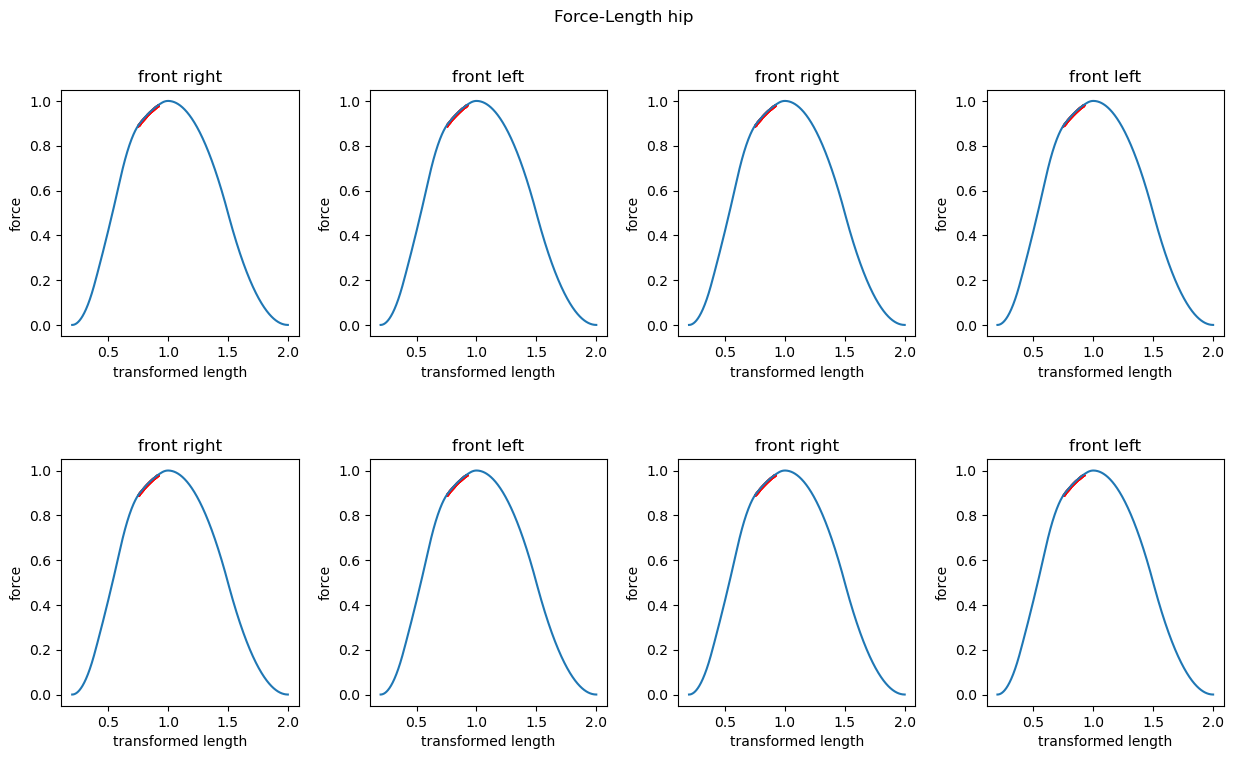

In [45]:
rows = 2
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(15, 8))

fig.subplots_adjust(wspace=0.3, hspace=0.5)

fig.suptitle("Force-Length hip")

for i, col in enumerate(hip_le.T):
    x = np.linspace(muscle_params_hip["lmin"], muscle_params_hip["lmax"], 1000)
    y = muscle_hip.FL(torch.Tensor(x))
    ax[i // cols, i % cols].plot(x, y)

    ax[i // cols, i % cols].scatter(x=col, y=hip_FL.T[i], s=0.1, color="red")

    ax[i // cols, i % cols].set_xlabel("transformed length")
    ax[i // cols, i % cols].set_ylabel("force")
    ax[i // cols, i % cols].set_title("front right" if i % 2 == 0 else "front left")

AttributeError: PathCollection.set() got an unexpected keyword argument 'fontsize'

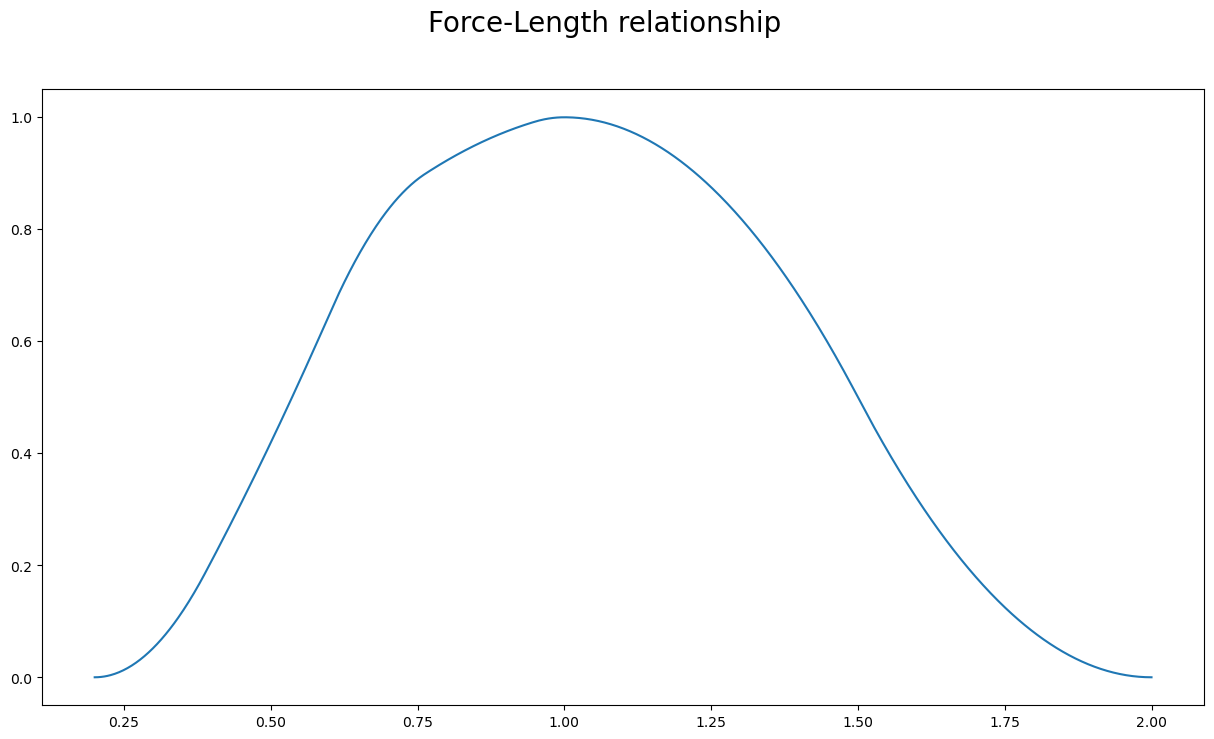

In [ ]:
rows = 1
cols = 1
fig, ax = plt.subplots(rows, cols, figsize=(15, 8))

fig.subplots_adjust(wspace=0.3, hspace=0.5)

fig.suptitle("Force-Length relationship", fontsize=20)


ax.plot(np.linspace(muscle_params_hip["lmin"], muscle_params_hip["lmax"], 1000), muscle_hip.FL(torch.Tensor(x)))
ax.scatter(x=hip_le.T[0], y=hip_FL.T[0], s=4.0, color="red", label='goal area')
ax.set_ylabel("Force %", fontsize=20)
ax.set_xlabel("relative length", fontsize=20)
ax.grid(True)
ax.legend()
# for i, col in enumerate(hip_le.T):
#     x = np.linspace(muscle_params_hip["lmin"], muscle_params_hip["lmax"], 1000)
#     y = muscle_hip.FL(torch.Tensor(x))
#     ax[i // cols, i % cols].plot(x, y)

#     ax[i // cols, i % cols].scatter(x=col, y=hip_FL.T[i], s=0.1, color="red")

#     ax[i // cols, i % cols].set_xlabel("transformed length")
#     ax[i // cols, i % cols].set_ylabel("force")
#     ax[i // cols, i % cols].set_title("front right" if i % 2 == 0 else "front left")

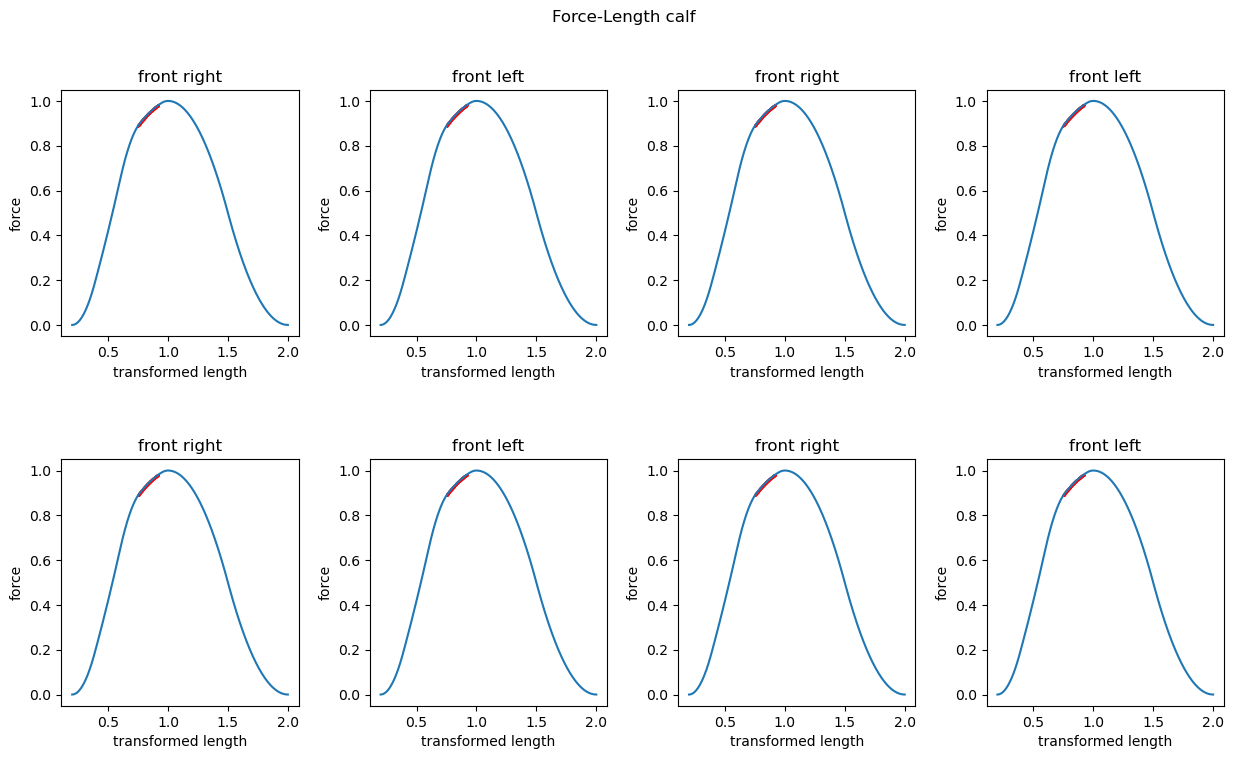

In [47]:
rows = 2
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(15, 8))

fig.subplots_adjust(wspace=0.3, hspace=0.5)

fig.suptitle("Force-Length calf")

for i, col in enumerate(calf_le.T):
    x = np.linspace(muscle_params_calf["lmin"], muscle_params_calf["lmax"], 1000)
    y = muscle_calf.FL(torch.Tensor(x))
    ax[i // cols, i % cols].plot(x, y)

    ax[i // cols, i % cols].scatter(x=col, y=calf_FL.T[i], s=0.1, color="red")

    ax[i // cols, i % cols].set_xlabel("transformed length")
    ax[i // cols, i % cols].set_ylabel("force")
    ax[i // cols, i % cols].set_title("front right" if i % 2 == 0 else "front left")

In [48]:
import torch
import matplotlib.pyplot as plt

def FV(lce_dot: torch.Tensor) -> torch.Tensor:
        """
        Force velocity
        Input:
            :lce_dot: tensor of muscle velocities [Nenv, Nactuator]
        """
        fvmax = 0.7
        vmax = 30.0
        device = "cpu"
        
        c = fvmax - 1
        velocity = lce_dot

        eff_vel = torch.div(velocity, vmax)

        c_result = torch.zeros_like(
            eff_vel,
            dtype=torch.float32,
            device=device,
            requires_grad=False,
        )

        c_result = torch.where(
            (eff_vel > c),
            torch.tensor([fvmax], dtype=torch.float32, device=device),
            c_result,
        )

        x = torch.sub(
            fvmax,
            torch.div(torch.mul(torch.sub(c, eff_vel), torch.sub(c, eff_vel)), c),
        )
        c_result = torch.where(eff_vel <= c, x, c_result)

        x = torch.mul(torch.add(eff_vel, 1), torch.add(eff_vel, 1))
        c_result = torch.where(eff_vel <= 0, x, c_result)

        c_result = torch.where(
            (eff_vel < -1),
            torch.tensor([0], dtype=torch.float32, device=device),
            c_result,
        )

        return c_result

x = torch.arange(-20.0, 20.0, 0.001)

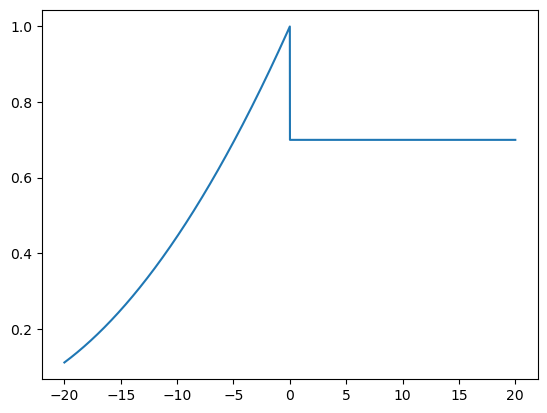

In [49]:
plt.plot(x, FV(x))

In [50]:
activation = pd.read_csv("muscle_activation_activation_experiment.csv", delimiter=";", header=None).astype(np.float64).to_numpy()
torque = pd.read_csv("applied_torque_activation_experiment.csv", delimiter=";", header=None).astype(np.float64).to_numpy()
pos = pd.read_csv("joint_pos_activation_experiment.csv", delimiter=";", header=None).astype(np.float64).to_numpy()

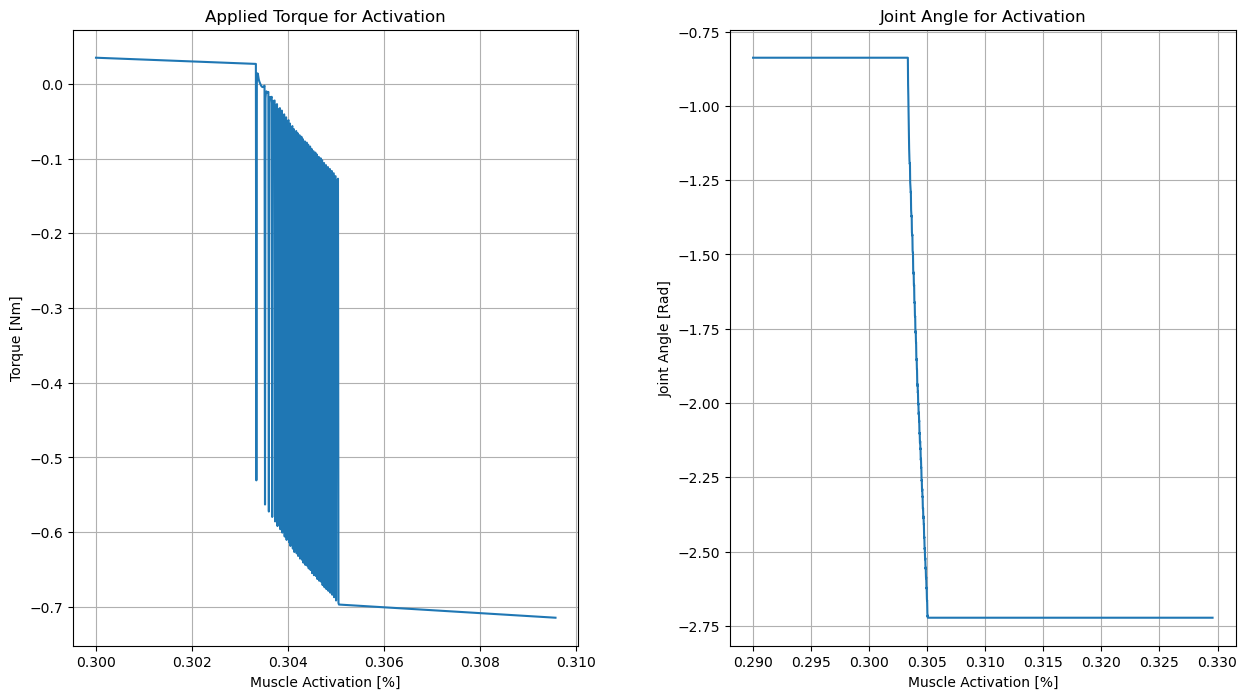

In [76]:
rows = 1
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(15, 8))

fig.subplots_adjust(wspace=0.3, hspace=0.5)

ax[0].plot(activation[11000:-5000], torque[11000:-5000])
ax[0].set_ylabel("Torque [Nm]")
ax[0].set_xlabel("Muscle Activation [%]")
ax[0].set_title("Applied Torque for Activation")
ax[0].grid(True)

ax[1].plot(activation[10000:-3000], pos[10000:-3000])
ax[1].set_ylabel("Joint Angle [Rad]")
ax[1].set_xlabel("Muscle Activation [%]")
ax[1].set_title("Joint Angle for Activation")
ax[1].grid(True)